# Extraction Image

Maintenant qu'on a pu observer la faisabilité de l'extraction des informations du texte, on va pouvoir s'intéresser aux images fournies sur l'annonce afin d'étudier la faisabilité d'une classification des objets par cette méthode.

On va pour cela mettre en place plusieurs modèles afin d'évaluer leurs performances, et de voir si on obtient des résultats satisfaisants.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

from matplotlib.image import imread

pd.options.mode.chained_assignment = None  # default='warn'


import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import vgg16, resnet, inception_v3, resnet_v2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [2]:
#On réimporte les données
sample = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

#Les images sont contenues dans la feature *image*
images = sample[['image','product_category_tree']]
images.rename({'product_category_tree' : 'category'}, axis=1, inplace=True)
images

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>..."
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1047,5912e037d12774bb73a2048f35a00009.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."


On va commencer par attribuer à chaque image sa catégorie réelle, pour ça on applique le même traitement que précédemment et on récupère la catégorie la plus large dans *product_category_tree*.
On modifie également l'url des images afin qu'elles puissent être lues dans ntore notebook.

In [3]:
# On modifie le path
images['image'] = 'Images/' + images['image']

# On garde la catégorie la plus large
images['category'] = images['category'].apply(lambda x : x.split('>>')[0])
images['category'] = images['category'].apply(lambda x : re.sub(r"[^a-zA-Z0-9& ]", "", x))
images['category'] = images['category'].apply(lambda x :x.strip())
images

,image,category
0,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing
...,...,...
1045,Images/958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care
1046,Images/fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care
1047,Images/5912e037d12774bb73a2048f35a00009.jpg,Baby Care
1048,Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care


In [4]:
images.groupby('category').count()

,image
category,
Baby Care,150
Beauty and Personal Care,150
Computers,150
Home Decor & Festive Needs,150
Home Furnishing,150
Kitchen & Dining,150
Watches,150


On remarque que les produits sont bien répartis dans les catégories, avec des quantités égales pour chaque.

Home Furnishing


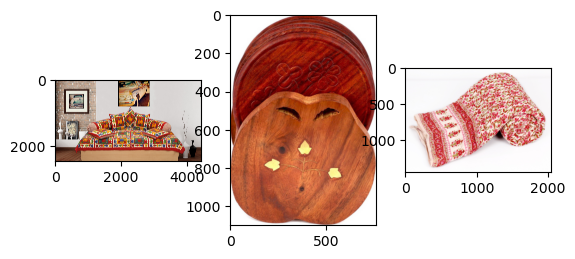

Baby Care


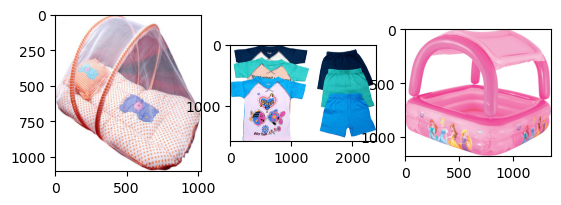

Watches


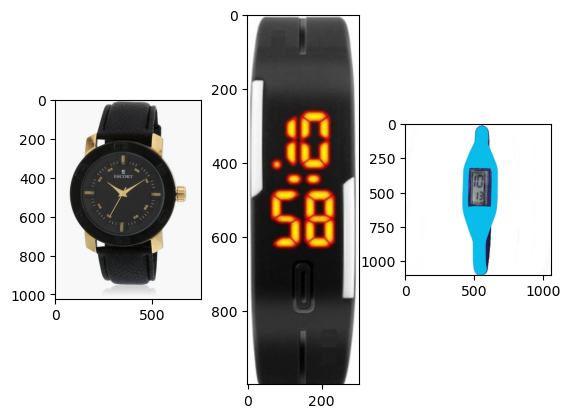

Home Decor & Festive Needs


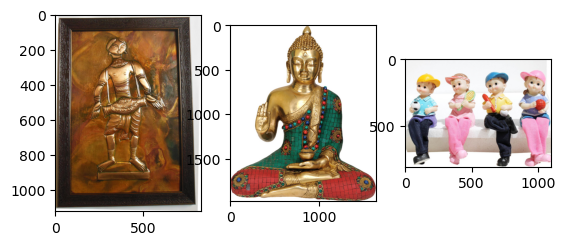

Kitchen & Dining


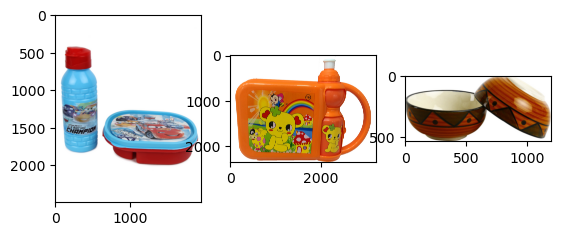

Beauty and Personal Care


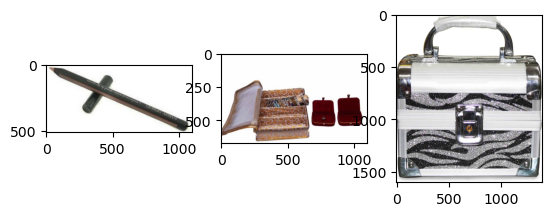

Computers


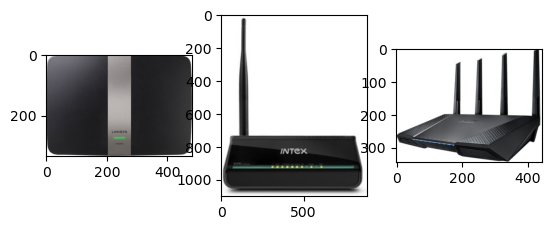

In [5]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [images['image'][i] for i in range(len(images)) if images['category'][i]==name]
    return pd.Series(list_image_name)


cat_lists = pd.DataFrame()
for cat in images['category'].unique() :
    cat_lists = pd.concat([cat_lists,list_fct(cat)], axis=1) 
cat_lists.columns = images['category'].unique()
cat_lists


for name in cat_lists.columns :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = cat_lists[name][i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

## Méthode SIFT

La méthode SIFT consiste en l'utilisation de descripteurs qui sont générés et qui vont renvoyer une certaine quantité d'informations sur l'image. L'intérêt va être de créer les descripteurs correspondants à chaque image, puis de regrouper ces descripteurs ensemble afin de créer des clusters. A partir des clusters, on pourra ensuite construire pour chaque image un histogramme représentant la quantité de descripteurs contenus dans chaque cluster pour chaque image, et on pourra ensuite créer une classification des images à partir de ça.

### Affichage des descripteurs

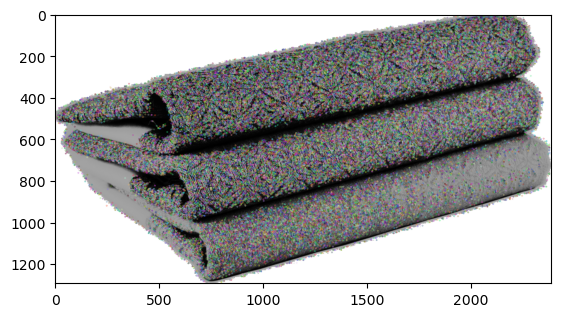

Descripteurs :  (47651, 128)

[[ 85. 113.  31. ...   0.   0.   0.]
 [ 29.  80.  73. ...   0.   0.   0.]
 [ 10.  67. 115. ...   0.   0.  22.]
 ...
 [  0.   0.   0. ...   0.   0.  13.]
 [ 40.   0.   0. ...   0.   0.  51.]
 [ 37.   1.   0. ...   0.   0.   0.]]


In [6]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(images['image'][1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

On peut voir que cette image contient plus de 98000 descripteurs, avec pour chaque descripteur un vecteur de taille 128.

On va maintenant calculer tous les descripteurs de toutes les images.

### Pré traitement

Pour chaque image on passe en nuance de gris et on égalise les teintes. Ensuite on va créer des listes de descripteurs pour chaque image afin de les identifier par la suite, ainsi qu'une liste avec l'ensemble de tous les descripteurs afin de créer nos clusters.

In [7]:
with tf.device('/gpu:0'):     
    import time
    sift_keypoints = []
    temps1=time.time()
    sift = cv2.xfeatures2d.SIFT_create()

    for image_num in range(len(images)) :
        image = cv2.imread(images['image'][image_num],0) # nuances de gris
        res = cv2.equalizeHist(image)   # egalisation
        kp, des = sift.detectAndCompute(res, None) #detection des descripteurs
        sift_keypoints.append(des)

    sift_keypoints_by_img = np.asarray(sift_keypoints) # descripteurs par image 
    sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0) # tous le descripteurs

    print()
    print("Nombre de descripteurs : ", sift_keypoints_all.shape)

    duration1=time.time()-temps1
    print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

C:\Users\Helios\AppData\Local\Temp\ipykernel_39164\2741480491.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints) # descripteurs par image



Nombre de descripteurs :  (9051349, 128)
temps de traitement SIFT descriptor :           286.38 secondes


In [8]:
from sklearn import cluster, metrics

temps1=time.time()

# On prend la racine carrée du nombre de prédicteurs comme k
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=10, batch_size=4096)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  3009
Création de 3009 clusters de descripteurs ...
temps de traitement kmeans :           151.40 secondes


## Création des features des images

Maintenant qu'on a crée des clusters avec l'ensemble de nos descripteurs, on va pouvoir classer les images. Pour cela on va donc prédire pour chaque descripteur dans chaque image le cluster correspondant. Puis on réalisera un histogramme qui compte pour chaque image le nombre de descripteurs dans chaque cluster.

In [9]:
from sklearn import preprocessing

#On crée un label our chaque catégorie
le = preprocessing.LabelEncoder()
le.fit(images['category'])
images['label'] = le.transform(images['category'])
images

,image,category,label
0,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,Images/958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,Images/fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,Images/5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [10]:
def TSNE_visu(X_tsne, y_cat_num, labels, ARI, title='') :
    fig = plt.figure(figsize=(15,6))
    
    plt.title(title)
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=list(images['category'].unique()), loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [11]:
# Création des histogrammes
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Matrice avec tous les histogrammes
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :  
    hist = build_histogram(kmeans, image_desc, i) 
    hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


temps de création histogrammes :            33.67 secondes


Maintenant qu'on a crée des histogrammes pour chaque image, on va réduire la dimension de toutes ces données afin de pouvoir les afficher sur notre graphe 2D comme précédemment.

In [12]:
from sklearn.decomposition import PCA

# On applique tout d'abord un PCA en gardant 99 de variance
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.99, random_state=10)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 3009)
Dimensions dataset après réduction PCA :  (1050, 731)


In [13]:
# Puis on réduit jusqu'à 2 dimensions par un TSNE

from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=10)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = images['category']
display(df_tsne)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,tsne1,tsne2,class
0,7.130139,20.159300,Home Furnishing
1,6.308713,10.275079,Baby Care
2,8.621391,16.814938,Baby Care
3,7.836026,7.900264,Home Furnishing
4,5.401370,11.199067,Home Furnishing
...,...,...,...
1045,-4.266868,-8.623550,Baby Care
1046,-18.478935,6.681221,Baby Care
1047,3.094533,-4.023673,Baby Care
1048,3.905383,12.713035,Baby Care


On affiche maintenant sur un graph 2D les produits avec la catégorie réelle associée àa la couleur.

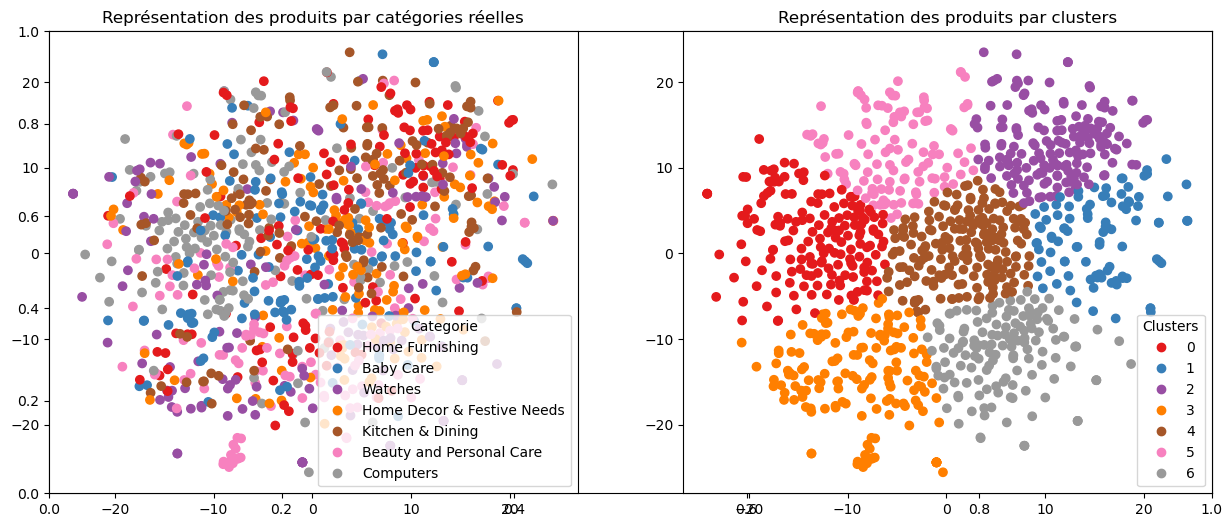

ARI :  0.0627


In [14]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = images['category']

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
ARI = np.round(metrics.adjusted_rand_score(images['label'], df_tsne['cluster']),4)

TSNE_visu(X_tsne, images['label'],df_tsne['cluster'], ARI)

On peut voir qu'avec cette méthode le résultat obtenu est vraiment mauvais, en plus d'être extrêmement long à traiter. Cela s'explique par la faible quantité de produits pour chaque catégorie, surtout qu'on remarque en regardant les images affichées plus haut que les images peuvent être très différents même au sein d'une même catégorie. Nos données sont donc insuffisantes pour obtenir un résultats correct avec cette méthode. 

Nous allons donc maintenant essayer une autre technique d'analyse d'image afin de déterminer si les résultats satisfont ou non la faisabilité de notre projet.

## CNN Transfer Learning

Dans le cadre du transfer learning, on va donc importer un modèle pré-existant, ici VGG16 ou autre, qui va venir effectuer de nombreux traitements sur les images afin d'en retirer les features qui la caractérise. Ce modèle pré-entraîné devrait permettre de surmonter le problème qu'on a pu rencontrer précédemment dû au manque de données. On vérifiera ensuite si ce traitement permet ou non de catégoriser les produits afin de conclure sur la faisabilité de notre projet.

### VGG 16

VGG16 est un réseau de neurones convolutif à 16 couches, pré entréaîné sur un échantillon de plus d'1 million d'images qu'il sait catégoriser. On a donc ici un modèle déjà prêt et possédant beaucoup plus d'informations qui va permettre d'obtenir de meilleurs résultats.

In [15]:
base_model = vgg16.VGG16()
model_vgg = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model_vgg.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

On voit ici le fonctionnement du modèle, qui enchaîne donc des opérations de convolutions et de pooling afin de traiter les informations de l'image.

On commence par extraire les features de chaque image en utilisant un preprocessing correspondant à notre modèle.

In [17]:
with tf.device('/gpu:0'):
    images_features = []
    i=0 
    for image_file in images['image'] :
        if i%100 == 0 : print(i)
        i +=1
        image = load_img(image_file, target_size=(224, 224))
        image = img_to_array(image) 
        image = np.expand_dims(image, axis=0)
        image = vgg16.preprocess_input(image)
        images_features.append(model_vgg.predict(image, verbose=0)[0]) # predict from pretrained model

    images_features = np.asarray(images_features)
    images_features.shape

0
100
200
300
400
500
600


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


On vient ensuite réduire les dimensions de ces features, de la même façon qu'auparavant afin de les afficher sur un graph 2D.

In [18]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = PCA(n_components=0.99, random_state=10)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


In [19]:
from sklearn import manifold, decomposition

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=10)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de T-SNE :             3.80 secondes


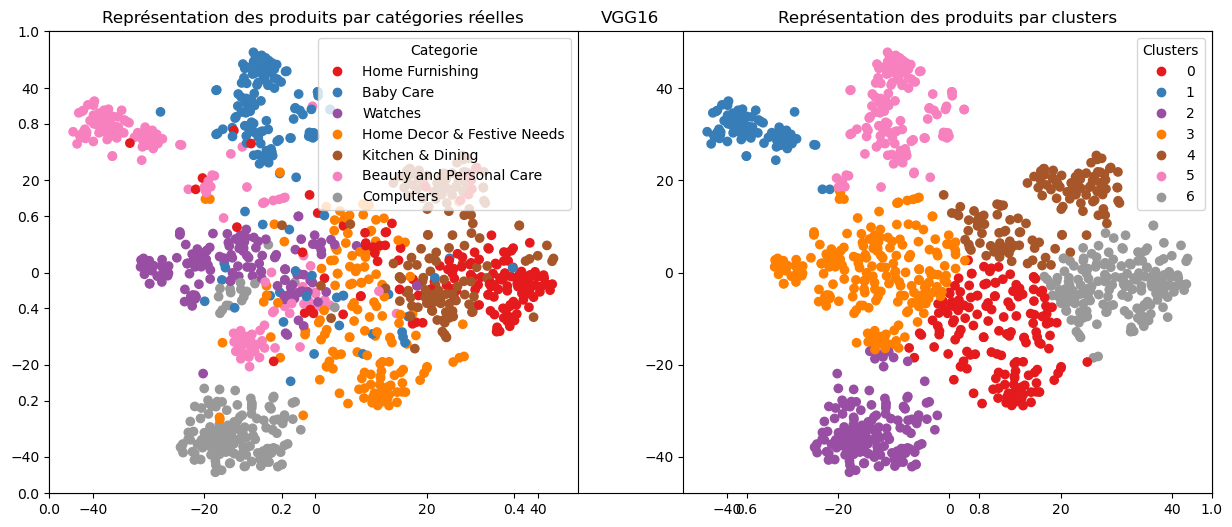

ARI :  0.4865


In [30]:
from sklearn import cluster, metrics

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = images['category']

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
ARI = np.round(metrics.adjusted_rand_score(images['label'], df_tsne['cluster']),4)
VGG_score=ARI

TSNE_visu(X_tsne, images['label'],df_tsne['cluster'], ARI, title='VGG16')

Les résultats obtenus sont plutôt satisfaisants, et permettent déjà de conclure à la faisabilité de notre projet. On pourrait cependant se pencher sur d'autes modèles que VGG16 afin de comparer les performances selon les différentes architectures. De plus le temps total de traitement pour ce modèle est d'environ 90s ce qui est très bon.

In [17]:
def CNN_transfer(model, module, size=(224,224), title=''):
    
    temps1 = time.time()
    images_features = []
    i=0 
    for image_file in images['image'] :
        if i%100 == 0 : print(i)
        i +=1
        image = load_img(image_file, target_size=size)
        image = img_to_array(image) 
        image = np.expand_dims(image, axis=0)
        image = module.preprocess_input(image)
        images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

    images_features = np.asarray(images_features)
    images_features.shape
    
    print(images_features.shape)
    pca = PCA(n_components=0.99, random_state=10)
    feat_pca= pca.fit_transform(images_features)
    print(feat_pca.shape)

    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=10)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = images['category']

    cls = cluster.KMeans(n_clusters=7, n_init=100)
    cls.fit(X_tsne)

    df_tsne["cluster"] = cls.labels_
    ARI = np.round(metrics.adjusted_rand_score(images['label'], df_tsne['cluster']),4)

    TSNE_visu(X_tsne, images['label'],df_tsne['cluster'], ARI, title) 

    plt.show()

    labels = images['label']
    print(str(model))
    print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
    
    duration1=time.time()-temps1
    print("Temps total : ", "%15.2f" % duration1, "secondes")
    return metrics.adjusted_rand_score(labels, cls.labels_)

## ResNet152

In [41]:
base_model = resnet.ResNet152()
model_rn152 = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model_rn152.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block6_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block6_2_relu[0][0]']    
                                                                                                  
 conv3_block6_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block6_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block8_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block13_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block13_1_relu[0][0]']   
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block13_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block13_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_2_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block16_1_relu[0][0]']   
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block19_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block22_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block22_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block22_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block22_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block22_1_relu[0][0]']   
                                                                                                  
 conv4_block22_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_2_conv[0][0]']   
 lization)

 conv4_block25_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block24_out[0][0]']      
                                                                                                  
 conv4_block25_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block25_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block27_out[0][0]']      
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block28_1_relu[0][0]']   
          

                                )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block30_out[0][0]']      
                                                                                                  
 conv4_block31_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block31_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block31_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block33_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block34_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block33_out[0][0]']      
                                                                                                  
 conv4_block34_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block34_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block34_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block34_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block36_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block36_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block36_out[0][0]']      
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)       

                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 2D)                                                                                              
                                                                                                  
Total params: 58,370,944
Trainable params: 58,219,520
Non-trainable params: 151,424
__________________________________________________________________________________________________
None


0
100
200
300
400
500
600


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000
(1050, 2048)
(1050, 726)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


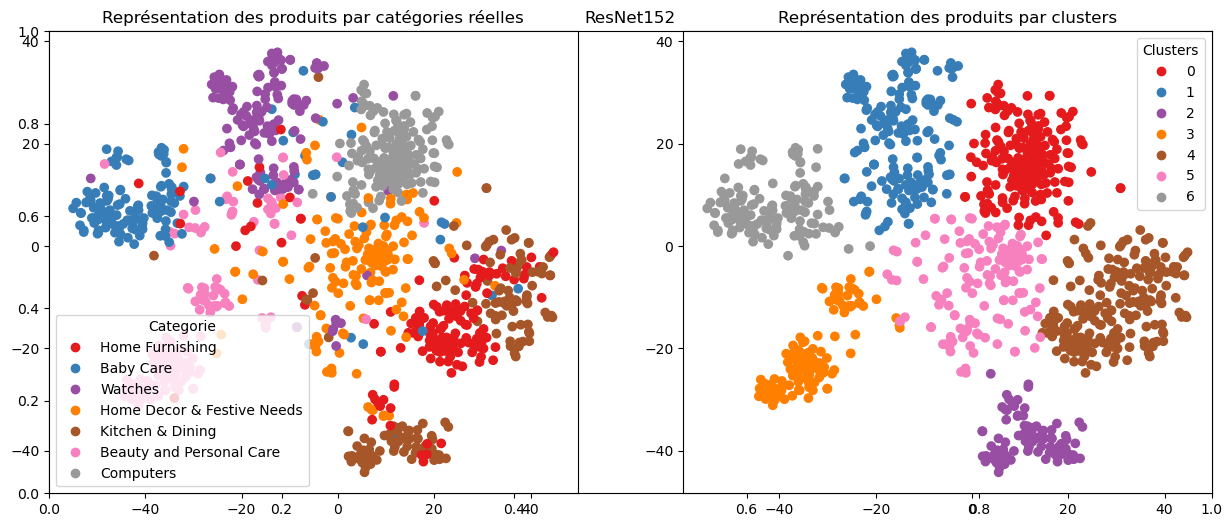

ARI :  0.5556
ARI :  0.5556222763291442
Temps total :           146.32 secondes


In [42]:
with tf.device('/gpu:0'):    
    rn152_score = CNN_transfer(model_rn152, resnet, title='ResNet152')

Avec ResNet, on obtient un score nettement meilleur, cependant le temps de traitement est rallongé.

## Inception V3

In [43]:
base_model = inception_v3.InceptionV3()
model_inc = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model_inc.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

 conv2d_199 (Conv2D)            (None, 35, 35, 32)   6144        ['average_pooling2d_18[0][0]']   
                                                                                                  
 batch_normalization_193 (Batch  (None, 35, 35, 64)  192         ['conv2d_193[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_195 (Batch  (None, 35, 35, 64)  192         ['conv2d_195[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_198 (Batch  (None, 35, 35, 96)  288         ['conv2d_198[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_210 (Conv2D)            (None, 35, 35, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_210 (Batch  (None, 35, 35, 64)  192         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_210 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_210[0][0]']
                                                                                                  
 conv2d_208 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_21

                                                                                                  
 activation_217 (Activation)    (None, 17, 17, 96)   0           ['batch_normalization_217[0][0]']
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_214[0][0]',         
                                                                  'activation_217[0][0]',         
                                                                  'max_pooling2d_16[0][0]']       
                                                                                                  
 conv2d_22

 mixed4 (Concatenate)           (None, 17, 17, 768)  0           ['activation_218[0][0]',         
                                                                  'activation_221[0][0]',         
                                                                  'activation_226[0][0]',         
                                                                  'activation_227[0][0]']         
                                                                                                  
 conv2d_232 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_232 (Batch  (None, 17, 17, 160)  480        ['conv2d_232[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_242 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_242 (Batch  (None, 17, 17, 160)  480        ['conv2d_242[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_242[0][0]']
                                                                                                  
 conv2d_243 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 17, 17, 160)  480        ['conv2d_243[0][0]']             
 Normaliza

 activation_252 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_252[0][0]']
                                                                                                  
 conv2d_253 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_252[0][0]']         
                                                                                                  
 batch_normalization_253 (Batch  (None, 17, 17, 192)  576        ['conv2d_253[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_253 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_249 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_261 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_261[0][0]']
                                                                                                  
 conv2d_258 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_262 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_258 (Batch  (None, 17, 17, 192)  576        ['conv2d_258[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_272 (Conv2D)            (None, 8, 8, 192)    245760      ['average_pooling2d_25[0][0]']   
                                                                                                  
 batch_normalization_264 (Batch  (None, 8, 8, 320)   960         ['conv2d_264[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_266 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_266[0][0]']
                                                                                                  
 activation_267 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_267[0][0]']
          

                                                                                                  
 activation_275 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_275[0][0]']
                                                                                                  
 activation_276 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_276[0][0]']
                                                                                                  
 activation_279 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_279[0][0]']
                                                                                                  
 activation_280 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 batch_normalization_281 (Batch  (None, 8, 8, 192)   576         ['conv2d_281[0][0]']             
 Normaliza

0
100
200
300
400
500
600


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000
(1050, 2048)
(1050, 696)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


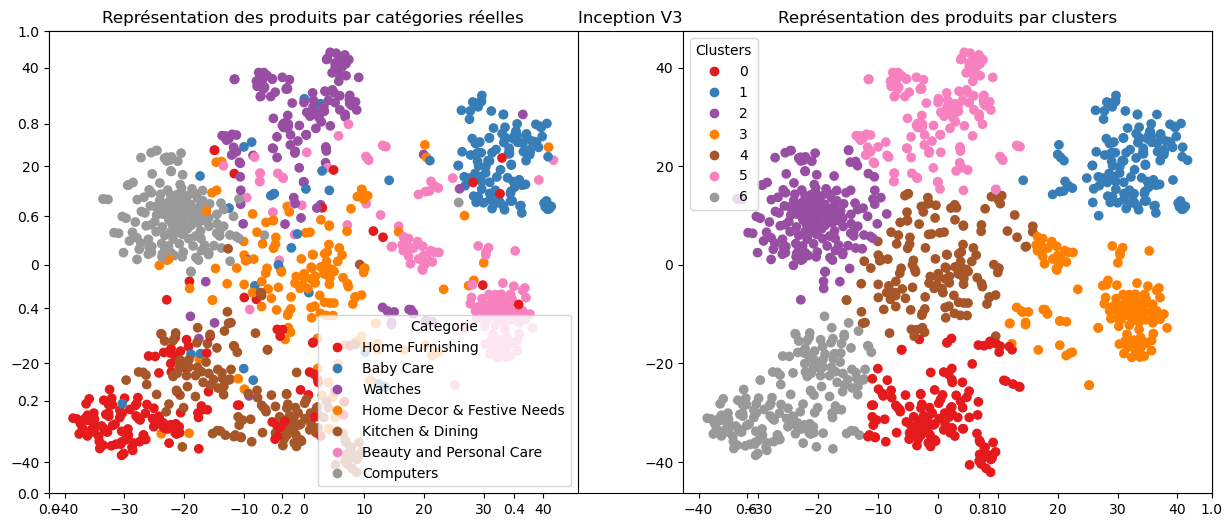

ARI :  0.5404
ARI :  0.5403890573330623
Temps total :            92.53 secondes


In [44]:
with tf.device('/gpu:0'):
    inc_score = CNN_transfer(model_inc, inception_v3, (299,299), 'Inception V3')

Le score est ici encore une fois très bon, un peu en dessous de ResNet mais avec un temps de traitement plus court.

## ResNet v2

In [45]:
base_model = resnet_v2.ResNet152V2()
model_rnv2 = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model_rnv2.summary())

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

                                                                 ]                                
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
          

 conv3_block7_out (Add)         (None, 28, 28, 512)  0           ['conv3_block6_out[0][0]',       
                                                                  'conv3_block7_3_conv[0][0]']    
                                                                                                  
 conv3_block8_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block8_preact_relu[0][0]'
          

                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

                                )                                 'conv4_block4_3_conv[0][0]']    
                                                                                                  
 conv4_block5_preact_bn (BatchN  (None, 14, 14, 1024  4096       ['conv4_block4_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 14, 14, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262144      ['conv4_block5_preact_relu[0][0]'
                                                                 ]                                
          

                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block7_2_pad[0][0]']     
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block7_2_relu[0][0]']    
          

 ivation)                       )                                                                 
                                                                                                  
 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block10_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
          

 conv4_block12_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block12_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block12_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block12_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 14, 14, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_conv[0][0]']   
                                                                                                  
 conv4_block13_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block12_out[0][0]']      
 Normaliza

 lization)                                                                                        
                                                                                                  
 conv4_block15_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block15_2_pad[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block17_out (Add)        (None, 14, 14, 1024  0           ['conv4_block16_out[0][0]',      
                                )                                 'conv4_block17_3_conv[0][0]']   
                                                                                                  
 conv4_block18_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block17_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block18_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block18_preact_relu[0][0]
          

 ng2D)                                                                                            
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block20_2_pad[0][0]']    
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block20_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block23_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block23_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block23_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block23_1_bn[0][0]']     
 on)      

                                                                                                  
 conv4_block25_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block25_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block25_out (Add)        (None, 14, 14, 1024  0           ['conv4_block24_out[0][0]',      
                                )                                 'conv4_block25_3_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block28_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block28_2_pad[0][0]']    
          

                                                                                                  
 conv4_block30_out (Add)        (None, 14, 14, 1024  0           ['conv4_block29_out[0][0]',      
                                )                                 'conv4_block30_3_conv[0][0]']   
                                                                                                  
 conv4_block31_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block31_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block31_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_blo

 conv4_block33_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block33_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block33_2_pad[0][0]']    
                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block36_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block36_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block36_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 512)    2359296     ['conv5_block2_2_pad[0][0]']     
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
          

0
100
200
300
400
500
600


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000
(1050, 2048)
(1050, 668)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


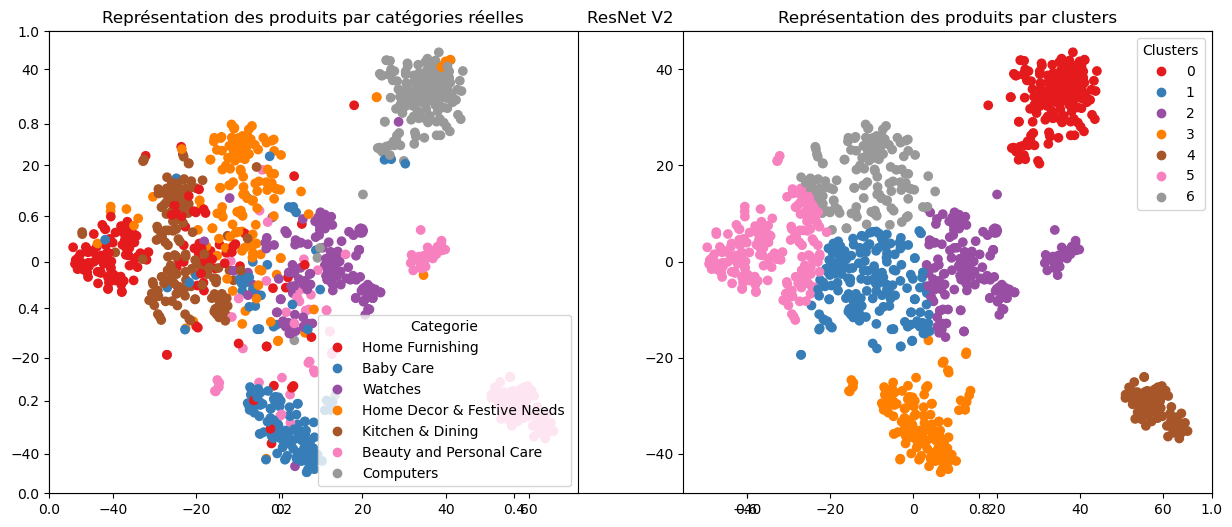

ARI :  0.4528
ARI :  0.452792804923976
Temps total :           123.69 secondes


In [46]:
with tf.device('/gpu:0'):
    rnv2_score = CNN_transfer(model_rnv2, resnet_v2, title='ResNet V2')

In [28]:
images.to_csv('prep_data.csv', index=False)

In [31]:
scores = pd.DataFrame([[VGG_score,rn152_score,inc_score,rnv2_score]])
scores.columns = ['VGG16', 'ResNet152','InceptionV3','ResNetV2']
scores

,VGG16,ResNet152,InceptionV3,ResNetV2
0,0.4865,0.555622,0.539292,0.452793


On peut voir ici que les résultats restent bons qu'importe le modèle, mais que le meilleur score est obtenu pour l'algorithme ResNet152, malgré un temps de traitement supérieur à Inception qui fait des résultats assez similaires.

Tous ces résultats permettent en tous cas de valider la faisabilité de notre projet et de passer à la suite.